In [31]:
import pandas as pd

data = pd.read_csv("blood_test_4.txt", delimiter=',', header=0)

# blood_test_4 uses 25 mL 20 wt% oxygen-containing horse blood in water.
# Every step, 1 mL initial blood was replaced by fully reduced blood 

In [32]:
data

,LED1 Timestamp (ms),LED1_PD1,LED1_PD2,LED2 Timestamp (ms),LED2_PD1,LED2_PD2
0,68000,304,380,68010,2524,3176
1,68020,307,379,68030,2517,3175
2,68040,309,386,68050,2524,3183
3,68060,311,384,68070,2521,3174
4,68080,322,390,68090,2523,3169
...,...,...,...,...,...,...
131719,2702380,398,485,2702390,3901,6464
131720,2702400,391,477,2702410,3900,6462
131721,2702420,394,478,2702430,3898,6454
131722,2702440,389,481,2702450,3901,6457


In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import math

plt.rcParams['figure.figsize'] = [10, 10]

d = 2 # mm
fs = 50 # Hz
xb = [3, 16] # min
xl = xb[0]
xh = xb[1]
interval = 3 # min

def denoise(sig, fs):
    ave = signal.savgol_filter(sig, 10*fs+1, 1)
#     bl = signal.savgol_filter(sig, 2000*fs+1, 1)-ave[0]
    bl = 0
    ex = ave-bl
    return ex

def diffAb(sig, fs):
    dn = denoise(sig, fs)
    i0 = dn[0]
    ab = []
    for i in range(len(dn)):
        ab.append(math.log10(i0*1./dn[i]))
    ab = np.array(ab)
    return np.roll(ab, -1)-ab

def diffDistance(sig_1, sig_2, distance, fs):
    dn_1 = denoise(sig_1, fs)
    dn_2 = denoise(sig_2, fs)
    i0_1 = dn_1[0]
    i0_2 = dn_2[0]
    ab_1 = []
    ab_2 = []
    for i in range(len(dn_1)):
        ab_1.append(math.log10(i0_1*1./dn_1[i]))
        ab_2.append(math.log10(i0_2*1./dn_2[i]))
    ab_1 = np.array(ab_1)
    ab_2 = np.array(ab_2)
    return (ab_1-ab_2)/distance

Single PD calculation

In [34]:
class StO2SinglePD:
    
    def __init__(self, time, red, nir, fs):
        self.time = time
        self.red = red
        self.nir = nir
        self.fs = fs

    def diffConc(self):
        extin_ox_RED = 0.011 # mm-1
        extin_ox_NIR = 0.028 # mm-1
        extin_deox_RED = 0.106 # mm-1
        extin_deox_NIR = 0.018 # mm-1
        dB = 2 # mm
        extin = np.array([[extin_deox_RED, extin_ox_RED],
                          [extin_deox_NIR, extin_ox_NIR]])
        extin_inv = np.linalg.inv(extin)
        
        red_ab_diff = diffAb(self.red, self.fs)
        nir_ab_diff = diffAb(self.nir, self.fs)
        ab_diff = np.vstack((red_ab_diff, nir_ab_diff))
        return (1/dB)*np.matmul(extin_inv, ab_diff)

    def tissueOximetry(self):
        conc_deox0 = 1 # mM
        conc_ox0 = 20 # mM

        conc_deox = conc_deox0
        conc_ox = conc_ox0
        sto2 = np.zeros(len(self.time))
        conc = np.zeros((2, len(self.time)))
        conc_diff = self.diffConc()
        
        for t in range(len(self.time)):
            sto2[t] = 100.*conc_ox/(conc_ox+conc_deox)
            conc[0, t] = conc_deox
            conc[1, t] = conc_ox
            conc_deox += conc_diff[0, t]
            conc_ox += conc_diff[1, t]
        return sto2, conc

time = (1/3000)*np.arange(0, len(data))
red_1 = np.array(data['LED1_PD1'])
red_2 = np.array(data['LED1_PD2'])
nir_1 = np.array(data['LED2_PD1'])
nir_2 = np.array(data['LED2_PD2'])

pd1 = StO2SinglePD(time, red_1, nir_1, fs)
pd2 = StO2SinglePD(time, red_2, nir_2, fs)

red_ex_1 = denoise(red_1, fs)
red_ex_2 = denoise(red_2, fs)
nir_ex_1 = denoise(nir_1, fs)
nir_ex_2 = denoise(nir_2, fs)

sto2_1, conc_1 = pd1.tissueOximetry()
sto2_2, conc_2 = pd2.tissueOximetry()

Double PD calculations

In [44]:
class StO2DoublePD:
    
    def __init__(self, time, red_1, red_2, nir_1, nir_2, d, fs):
        self.time = time
        self.red_1 = red_1
        self.red_2 = red_2
        self.nir_1 = nir_1
        self.nir_2 = nir_2
        self.d = d
        self.fs = fs
        
    def kmu(self):
        h = 0.1
        coeff_red = (1/3)/(1-h*660)
        coeff_nir = (1/3)/(1-h*950)
        k_mu_red = coeff_red*(np.log(10)*diffDistance(self.red_1, self.red_2, self.d, self.fs)-(2/self.d))**2
        k_mu_nir = coeff_nir*(np.log(10)*diffDistance(self.nir_1, self.nir_2, self.d, self.fs)-(2/self.d))**2
        return k_mu_red, k_mu_nir
    
    def tissueOximetry(self):
        extin_ox_RED = 0.011 # mm-1
        extin_ox_NIR = 0.028 # mm-1
        extin_deox_RED = 0.106 # mm-1
        extin_deox_NIR = 0.018 # mm-1
        dB = 2 # mm
        extin = np.array([[extin_deox_RED, extin_ox_RED],
                          [extin_deox_NIR, extin_ox_NIR]])
        extin_inv = np.linalg.inv(extin)
        k_mu_red, k_mu_nir = self.kmu()
        k_mu = np.vstack((k_mu_red, k_mu_nir))
        k_c = (1/np.log(10))*np.matmul(extin_inv, k_mu)
        k_c_hb = k_c[0]
        k_c_hbo2 = k_c[1]
        sto2 = 100*k_c_hbo2/(k_c_hb+k_c_hbo2)
        return sto2
    
pd = StO2DoublePD(time, red_1, red_2, nir_1, nir_2, d, fs)
sto2 = pd.tissueOximetry()

Plots

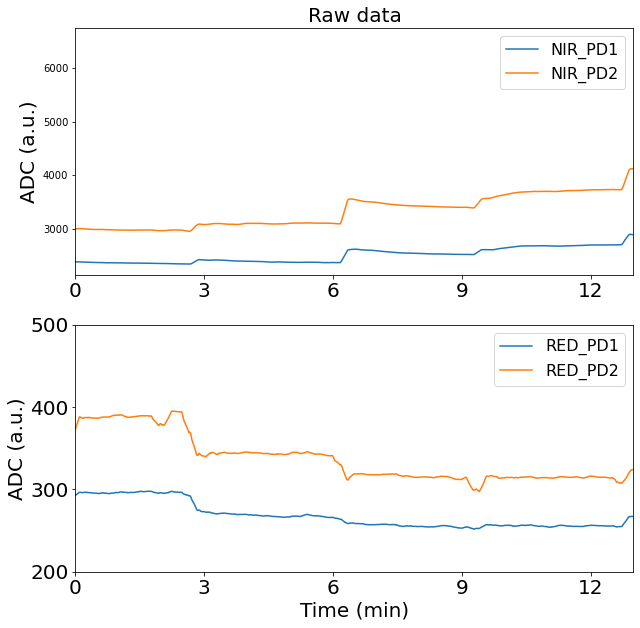

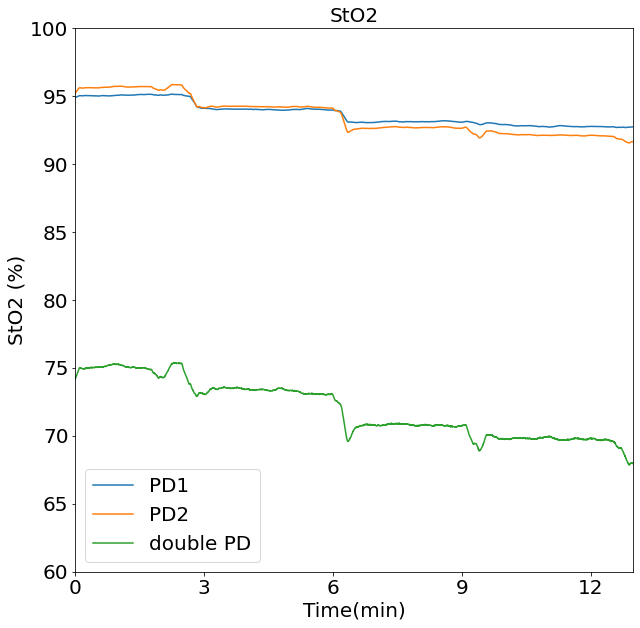

In [45]:
plt.subplot(211)
plt.title('Raw data', fontsize=20)
plt.plot(time, nir_ex_1)
plt.plot(time, nir_ex_2)

# plt.xlabel('Time (s)', fontsize=20)
plt.ylabel('ADC (a.u.)', fontsize=20)
plt.xlim([xl, xh])
plt.xticks(ticks=np.arange(xl, xh+1, interval), 
           labels=[str(n) for n in np.arange(0, xh-xl+1, interval)], fontsize=20)
# plt.ylim([2000, 4000])
# plt.yticks(ticks=np.arange(2000, 5000, step=1000), fontsize=20)
plt.legend(['NIR_PD1', 'NIR_PD2'], loc='upper right', fontsize=16)

plt.subplot(212)
plt.plot(time, red_ex_1)
plt.plot(time, red_ex_2)

plt.xlabel('Time (min)', fontsize=20)
plt.ylabel('ADC (a.u.)', fontsize=20)
plt.xlim([xl, xh])
plt.xticks(ticks=np.arange(xl, xh+1, interval), 
           labels=[str(n) for n in np.arange(0, xh-xl+1, interval)], fontsize=20)
plt.ylim([200, 500])
plt.yticks(np.arange(200, 600, step=100), fontsize=20)
plt.legend(['RED_PD1', 'RED_PD2'], loc='upper right', fontsize=16)
plt.show()

plt.plot(time, sto2_1)
plt.plot(time, sto2_2)
plt.plot(time, sto2)
plt.title("StO2", fontsize=20)
plt.xlabel("Time(min)", fontsize=20)
plt.ylabel("StO2 (%)", fontsize=20)
plt.xlim([xl, xh])
plt.xticks(ticks=np.arange(xl, xh+1, interval), 
           labels=[str(n) for n in np.arange(0, xh-xl+1, interval)], fontsize=20)
plt.ylim([60, 100])
plt.yticks(fontsize=20)
plt.legend(['PD1', 'PD2', 'double PD'], fontsize=20)
plt.show()


In [51]:
np.vstack((time, sto2_1, sto2_2, sto2)).transpose()

array([[0.00000000e+00, 9.52380952e+01, 9.52380952e+01, 7.30569220e+01],
       [3.33333333e-04, 9.52379016e+01, 9.52378208e+01, 7.30566888e+01],
       [6.66666667e-04, 9.52377080e+01, 9.52375464e+01, 7.30564555e+01],
       ...,
       [4.39070000e+01, 9.49925592e+01, 9.27862898e+01, 6.19867658e+01],
       [4.39073333e+01, 9.49924894e+01, 9.27861779e+01, 6.19865487e+01],
       [4.39076667e+01, 9.49924195e+01, 9.27860660e+01, 6.19863316e+01]])

In [52]:
np.savetxt("blood_test_4_res.txt", np.vstack((time, sto2_1, sto2_2, sto2)).transpose(), delimiter=',')